# Liver cancer survival analysis from imaging data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sksurv.ensemble import RandomSurvivalForest
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import brier_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.functions import StepFunction


from sklearn.model_selection import GridSearchCV, KFold


from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
    integrated_brier_score,
)

In [2]:
df = pd.read_excel('../data/complete_df.xlsx')
features_rf = pd.read_excel('../data/topfeatures_rf.xlsx')
anova_features_1 = pd.read_excel('../data/anova_scores_1.xlsx')
anova_features_6 = pd.read_excel('../data/anova_scores_6.xlsx')


# Data pre-processing

In [3]:
#df = df[df['survival_time'] < 40000]
X = df.drop(['Death', 'Date_of_lost_of_FU', 'classe_name', 'Local_relapse', 'Distant_relapse', 'patient_num', 'survival_time', 'local_relapse_time', 'distant_relapse_time', 'censorship_time', 'dead_after_one_year', 'dead_after_six_year'], axis=1)
df['Death'] = df['Death'].astype(bool)
df['survival_time'] = df['survival_time'].astype(float)
y_death = df['Death']
df['y'] = df['censorship_time'].fillna(df['survival_time'])
df['y'] = df['y'].fillna(df['y'].max(), downcast='infer', )

Y_death = list(zip(df['dead_after_six_year'], df['y']))

# Define the structured data type
dtype = np.dtype([('cens', '?'), ('time', '<f8')])

# Convert the list of tuples into a NumPy structured array
Y_death = np.array(Y_death, dtype=dtype)


/var/folders/wr/2dl0dqn97f75msdgk9cvcp2m0000gn/T/ipykernel_57707/3557419888.py:7: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df['y'] = df['y'].fillna(df['y'].max(), downcast='infer', )


# Data Imputation

In [4]:
imputer = IterativeImputer(random_state=100, max_iter=10)
imputer.fit(X)
X_imputed = imputer.transform(X)

# Feature Selection

In [28]:
selector = SelectKBest(f_classif, k=10) # k is the number of features to be selected
X_new = selector.fit_transform(X_imputed, y_death)

In [29]:

columns = X.columns
feature_scores = list(zip(selector.scores_,columns))
sorted_feature_scores = sorted(feature_scores,reverse=True)

num_list = []
col_list = []
for i in range(len(columns)):
   num_list.append((sorted_feature_scores[i])[0])
   col_list.append((sorted_feature_scores [i])[1])



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'original_gldm_DependenceVariance_ART'),
  Text(1, 0, 'original_shape_Maximum2DDiameterRow_ART'),
  Text(2, 0, 'original_firstorder_Skewness_ART'),
  Text(3, 0, 'original_shape_Maximum2DDiameterColumn_ART'),
  Text(4, 0, 'original_gldm_LargeDependenceEmphasis_ART'),
  Text(5, 0, 'original_shape_MinorAxisLength_ART'),
  Text(6, 0, 'original_shape_MajorAxisLength_ART'),
  Text(7, 0, 'original_shape_Maximum2DDiameterColumn_PORT'),
  Text(8, 0, 'original_shape_Maximum3DDiameter_ART'),
  Text(9, 0, 'original_shape_LeastAxisLength_ART'),
  Text(10, 0, 'original_gldm_LargeDependenceEmphasis_TARD'),
  Text(11, 0, 'original_ngtdm_Busyness_TARD'),
  Text(12, 0, 'original_shape_Maximum3DDiameter_PORT'),
  Text(13, 0, 'original_glcm_ClusterShade_PORT'),
  Text(14, 0, 'original_ngtdm_Busyness_VEIN'),
  Text(15, 0, 'original_gldm_LargeDependenceEmphasis_VEIN'),
  Text(16, 0, 'original_glcm_ClusterShade_ART'),
  Tex

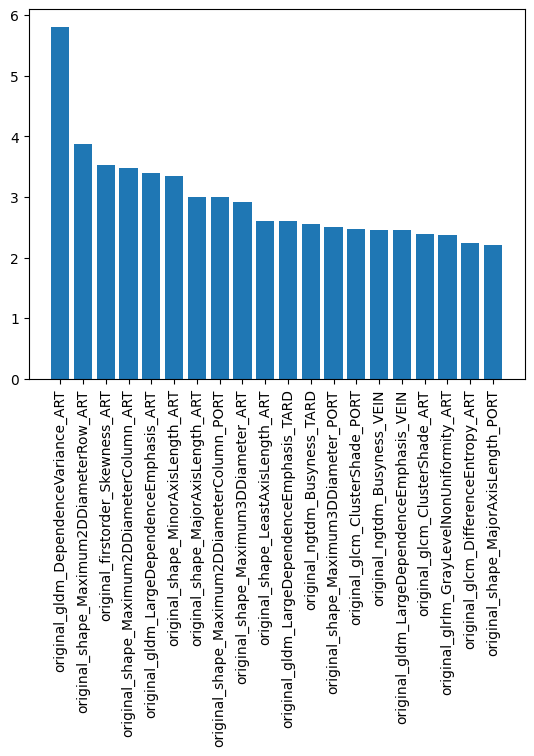

In [30]:
plt.bar(col_list[0:20],num_list[0:20])
plt.xticks(rotation=90)

### Features from first selection method

In [8]:
rf_topfeatures = features_rf['dead_after_six_year'][:20]
X_imp_df = pd.DataFrame(X_imputed, columns=X.columns)

X_topfeatures = X_imp_df.loc[:, rf_topfeatures]

In [47]:
anova_features = pd.read_excel('Feature_Selection_ANOVA.8.xlsx')
anova_features_1 = anova_features['Feature selection mort avant 1 an'][:13]
anova_features_6 = anova_features['Feature selection mort avant 6 ans'][:10]

X_imp_df = pd.DataFrame(X_imputed, columns=X.columns)

X_selected_1 = X_imp_df.loc[:,anova_features_1]
X_selected_6 = X_imp_df.loc[:,anova_features_6]

# Data Standardisation

In [31]:


scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X_new)


In [10]:

scaler_top = StandardScaler()  

X_scaled_one = scaler.fit_transform(X_topfeatures)


In [48]:
scaler = StandardScaler()  
X_scaled_1 = scaler.fit_transform(X_selected_1)

scaler = StandardScaler()  
X_scaled_6 = scaler.fit_transform(X_selected_6)

# Train/test Split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_death, test_size=0.25, random_state=20, stratify=df['classe_name']) 

# Cross-Validation

In [87]:
rf_grid = {
    'estimator__n_estimators': [50, 100, 200, 500],
   'estimator__max_depth': [None, 5, 10, 15],
   'estimator__min_samples_split': [2, 5, 10],
   'estimator__min_samples_leaf': [1, 5, 10],
}

svm_grid = {
    'estimator__gamma': [1, 0.1, 0.01, 0.05],
    'estimator__kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'estimator__degree': [2, 3, 4, 5],
}

coxnet_grid = {
    'estimator__l1_ratio': [0.001, 0.1, 0.5, 0.9, 0.9999],
   'estimator__max_iter': [100, 500, 1000]
}

gb_grid = {
    'estimator__learning_rate': [0.01, 0.1, 0.5, 1],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 5, 10],
}

coxph_grid = {
    'estimator__alpha': [0.1, 0.5, 1, 2, 0],
    'estimator__tol': [1e-4, 1e-3, 1e-2, 1e-1],

}



In [94]:
cv = KFold(n_splits=3, shuffle=True, random_state=1)

In [95]:
rsf = RandomSurvivalForest()
gbsa = GradientBoostingSurvivalAnalysis()
cox = CoxPHSurvivalAnalysis()
svm = FastKernelSurvivalSVM()
coxnet = CoxnetSurvivalAnalysis()


In [96]:
lower, upper = np.percentile(y_train["time"], [10, 90])
training_times = np.arange(lower, upper)

In [97]:
gcv_iauc_cox = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(cox, times=training_times),
    param_grid=coxph_grid,
    cv=cv,
    n_jobs=4,
    verbose=False
).fit(X_train, y_train)

print('Done with cox (LASSO)')

Done with cox (LASSO)


In [98]:
gcv_iauc_coxnet = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(coxnet, times=training_times),
    param_grid=coxnet_grid,
    cv=cv,
    n_jobs=4,
    verbose=False
).fit(X_train, y_train)

print('Done with cox (ElasticNet)')

/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization terminated early, you might want to i

Done with cox (ElasticNet)


/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100).
  self.estimator_ = self.estimator.fit(X, y, **fit_params)


In [99]:
gcv_iauc_svm = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(svm, times=training_times),
    param_grid=svm_grid,
    cv=cv,
    n_jobs=-1,
    verbose=False
).fit(X_train, y_train)

print('Done with SVM')

/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  self.estimator_ = self.estimator.fit(X, y, **fit_params)
/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been excee

Done with SVM


/Users/vincentlesang/miniconda3/envs/pythonenv/lib/python3.12/site-packages/sksurv/metrics.py:778: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  self.estimator_ = self.estimator.fit(X, y, **fit_params)


In [100]:
gcv_iauc_rsf = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(rsf, times=training_times),
    param_grid=rf_grid,
    cv=cv,
    n_jobs=4,
    verbose=False
).fit(X_train, y_train)


print('Done with RSF')

Done with RSF


In [101]:

gcv_iauc_gb = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(gbsa, times=training_times),
    param_grid=gb_grid,
    cv=cv,
    n_jobs=4,
).fit(X_train, y_train)

print('Done with GB')

Done with GB


In [103]:
models = [gcv_iauc_cox, gcv_iauc_coxnet, gcv_iauc_svm, gcv_iauc_rsf, gcv_iauc_gb]

for model in models:
    print('====================')
    print(model.best_estimator_)
    print('--------------------')
    print("Best parameters: " + str(model.best_params_))
    print("Best Score: " + str(model.best_score_))


as_cumulative_dynamic_auc_scorer(estimator=CoxPHSurvivalAnalysis(alpha=2,
                                                                 tol=0.1),
                                 times=array([  186.6,   187.6,   188.6, ..., 42184.6, 42185.6, 42186.6]))
--------------------
Best parameters: {'estimator__alpha': 2, 'estimator__tol': 0.1}
Best Score: 0.6934488200947345
as_cumulative_dynamic_auc_scorer(estimator=CoxnetSurvivalAnalysis(l1_ratio=0.001,
                                                                  max_iter=100),
                                 times=array([  186.6,   187.6,   188.6, ..., 42184.6, 42185.6, 42186.6]))
--------------------
Best parameters: {'estimator__l1_ratio': 0.001, 'estimator__max_iter': 100}
Best Score: 0.6863451273658846
as_cumulative_dynamic_auc_scorer(estimator=FastKernelSurvivalSVM(gamma=0.01,
                                                                 kernel='sigmoid',
                                                                 optim

# Model evaluation

In [105]:
surv_funcs = gcv_iauc_rsf.best_estimator_.predict_survival_function(X_test)

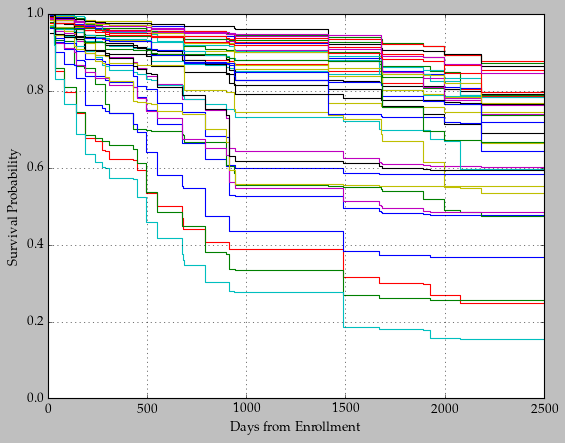

In [152]:
for fn in surv_funcs:
   plt.step(fn.x, fn(fn.x), where="post")


plt.ylim(0, 1)
plt.xlim(0, 2500)
plt.grid(True)
plt.xlabel("Days from Enrollment")
plt.ylabel("Survival Probability")
plt.savefig('survival_function_rf.pdf', format='pdf', dpi=300)
plt.show()

In [108]:
gb_score = gcv_iauc_gb.best_estimator_.score(X_test, y_test)
cox_score = gcv_iauc_cox.best_estimator_.score(X_test, y_test)
coxnet_score = gcv_iauc_coxnet.best_estimator_.score(X_test, y_test)
rsf_score = gcv_iauc_rsf.best_estimator_.score(X_test, y_test)
svm_score = gcv_iauc_svm.best_estimator_.score(X_test, y_test)

In [114]:
va_times = np.arange(200, 2000, 100)

risk_scores_rsf = gcv_iauc_rsf.best_estimator_.predict(X_test)
risk_scores_gb = gcv_iauc_gb.best_estimator_.predict(X_test)
risk_scores_svm = gcv_iauc_svm.best_estimator_.predict(X_test)
risk_scores_coxnet = gcv_iauc_coxnet.best_estimator_.predict(X_test)
risk_scores_cox = gcv_iauc_cox.best_estimator_.predict(X_test)

#risk_scores_cox = cox.predict(X_test)


cph_auc_rsf, cph_mean_auc_rsf = cumulative_dynamic_auc(y_test, y_test, risk_scores_rsf, va_times)
cph_auc_gb, cph_mean_auc_gb = cumulative_dynamic_auc(y_train, y_test, risk_scores_gb, va_times)
cph_auc_svm, cph_mean_auc_svm = cumulative_dynamic_auc(y_train, y_test, risk_scores_svm, va_times)
cph_auc_coxnet, cph_mean_auc_coxnet = cumulative_dynamic_auc(y_train, y_test, risk_scores_coxnet, va_times)
cph_auc_cox, cph_mean_auc_cox = cumulative_dynamic_auc(y_train, y_test, risk_scores_cox, va_times)

In [139]:
from matplotlib import rc
import seaborn as sns
# Using LaTeX style for fonts in matplotlib
plt.style.use('classic')  # Optional: use a classic style
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

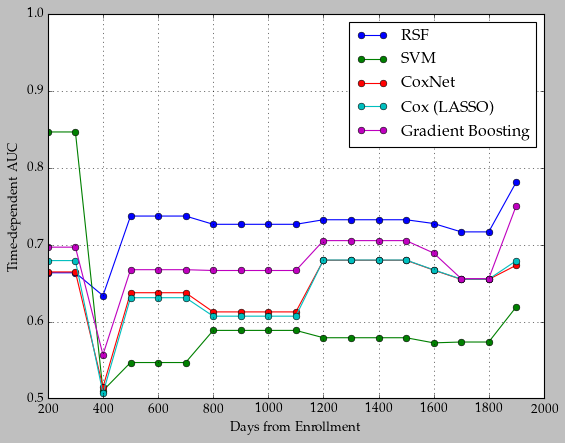

In [149]:

plt.plot(va_times, cph_auc_rsf, marker="o", label="RSF")
plt.plot(va_times, cph_auc_svm, marker="o", label="SVM")
plt.plot(va_times, cph_auc_coxnet, marker="o", label="CoxNet")
plt.plot(va_times, cph_auc_cox, marker="o", label="Cox (LASSO)")
plt.plot(va_times, cph_auc_gb, marker="o", label="Gradient Boosting")

plt.xlabel("Days from Enrollment")
plt.ylabel("Time-dependent AUC")
plt.ylim(0.5, 1)
plt.grid(True)
plt.legend()
plt.savefig('models_auc.pdf', dpi=300, format="pdf")

plt.show()


In [122]:
score_cindex = pd.Series(
    [
        cox_score,
        svm_score,
        coxnet_score,
        rsf_score,
        gb_score,
        0.5,
    ],
    index=["Cox (Lasso)", "SVM", "COX (Elastic Net)", 'Random Survival Forest', 'Gradient Boosting', "Random"],
    name="c-index",
)

score_cindex.round(3)

Cox (Lasso)               0.655
SVM                       0.648
COX (Elastic Net)         0.655
Random Survival Forest    0.714
Gradient Boosting         0.677
Random                    0.500
Name: c-index, dtype: float64

# Feature Importances

### Cox

In [124]:
result = permutation_importance(gcv_iauc_cox.best_estimator_, X_test, y_test, n_repeats=15, random_state=20)

In [126]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=col_list[0:10],
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
original_gldm_LargeDependenceEmphasis_ART,0.025756,0.023385
original_firstorder_Skewness_ART,0.023658,0.027388
original_shape_Maximum2DDiameterColumn_ART,0.020005,0.007522
original_gldm_DependenceVariance_ART,0.019817,0.043501
original_shape_MajorAxisLength_ART,0.013882,0.040766
original_shape_MinorAxisLength_ART,0.013808,0.068419
original_shape_Maximum2DDiameterColumn_PORT,0.002578,0.044842
original_shape_Maximum2DDiameterRow_ART,0.000638,0.006466
original_shape_LeastAxisLength_ART,-0.003669,0.044386
original_shape_Maximum3DDiameter_ART,-0.010581,0.070024


### SVM

In [ ]:
result = permutation_importance(gcv_iauc_svm.best_estimator_, X_test, y_test, n_repeats=15, random_state=20)

In [129]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=col_list[0:10],
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
original_shape_Maximum2DDiameterRow_ART,0.028890,0.057061
original_shape_Maximum2DDiameterColumn_PORT,0.026361,0.066318
original_shape_Maximum3DDiameter_ART,0.001211,0.073806
original_shape_Maximum2DDiameterColumn_ART,-0.011001,0.026333
original_shape_MajorAxisLength_ART,-0.015137,0.019045
original_gldm_DependenceVariance_ART,-0.019947,0.043101
original_gldm_LargeDependenceEmphasis_ART,-0.032100,0.039538
original_shape_MinorAxisLength_ART,-0.033489,0.037681
original_firstorder_Skewness_ART,-0.038459,0.037440
original_shape_LeastAxisLength_ART,-0.059178,0.032991


### Random Survival Forest

In [131]:
result = permutation_importance(gcv_iauc_rsf.best_estimator_, X_test, y_test, n_repeats=15, random_state=20)

In [133]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=col_list[0:10],
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
original_shape_Maximum3DDiameter_ART,0.011416,0.048028
original_shape_Maximum2DDiameterColumn_ART,0.011367,0.054370
original_shape_Maximum2DDiameterColumn_PORT,0.006958,0.033784
original_firstorder_Skewness_ART,-0.003140,0.036691
original_shape_LeastAxisLength_ART,-0.003924,0.035936
original_gldm_DependenceVariance_ART,-0.005603,0.037396
original_shape_Maximum2DDiameterRow_ART,-0.017537,0.062031
original_shape_MajorAxisLength_ART,-0.022174,0.044007
original_gldm_LargeDependenceEmphasis_ART,-0.025312,0.030088
original_shape_MinorAxisLength_ART,-0.027137,0.053443


### CoxNet

In [134]:
result = permutation_importance(gcv_iauc_coxnet.best_estimator_, X_test, y_test, n_repeats=15, random_state=20)

In [135]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=col_list[0:10],
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
original_shape_MajorAxisLength_ART,0.019214,0.043461
original_gldm_DependenceVariance_ART,0.019194,0.038758
original_shape_MinorAxisLength_ART,0.013414,0.066893
original_gldm_LargeDependenceEmphasis_ART,0.012409,0.012046
original_shape_Maximum2DDiameterColumn_PORT,0.006590,0.031784
original_shape_LeastAxisLength_ART,0.005964,0.043600
original_firstorder_Skewness_ART,0.005082,0.006516
original_shape_Maximum2DDiameterColumn_ART,0.003225,0.004337
original_shape_Maximum2DDiameterRow_ART,0.001892,0.001792
original_shape_Maximum3DDiameter_ART,-0.005207,0.074156


### Gradient Boosting

In [136]:
result = permutation_importance(gcv_iauc_gb.best_estimator_, X_test, y_test, n_repeats=15, random_state=20)

In [138]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=col_list[0:10],
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
original_shape_Maximum2DDiameterColumn_ART,0.030368,0.035958
original_gldm_LargeDependenceEmphasis_ART,0.024985,0.038225
original_shape_LeastAxisLength_ART,0.020829,0.022590
original_shape_MinorAxisLength_ART,0.005095,0.003663
original_shape_Maximum2DDiameterColumn_PORT,0.000000,0.000000
original_firstorder_Skewness_ART,-0.000560,0.023549
original_shape_Maximum2DDiameterRow_ART,-0.011808,0.021098
original_shape_MajorAxisLength_ART,-0.033770,0.016319
original_gldm_DependenceVariance_ART,-0.054048,0.070861
original_shape_Maximum3DDiameter_ART,-0.084534,0.056458
